# Introducción al Proyecto

En este proyecto, nuestro objetivo es construir un sistema de pronóstico de ventas que permita a la empresa anticipar la demanda y planificar adecuadamente el espacio de almacenamiento necesario en una nueva ubicación. Para lograr esto, llevamos a cabo varios pasos clave:

+ Carga y Preparación de Datos: Empezamos con la importación y limpieza de datos de ventas históricos, preparándolos para el análisis.

+ Análisis de Series Temporales: Exploramos las propiedades fundamentales de nuestras series temporales de ventas, como la tendencia, la estacionalidad, y la estacionariedad, utilizando pruebas estadísticas y visualizaciones.

+ Construcción del Modelo ARIMA: Desarrollamos un modelo ARIMA, que es un enfoque clásico en el pronóstico de series temporales, ajustándolo a los datos históricos de ventas diferenciadas para hacerlo estacionario.

+ Validación y Pruebas: Validamos el modelo utilizando técnicas de validación cruzada y luego lo probamos contra un conjunto de datos de prueba para evaluar su precisión.

+ Guardado del Modelo: Finalmente, guardamos el modelo entrenado para su uso futuro en la toma de decisiones de negocio.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import itertools
from joblib import dump
import scipy.stats as stats
from math import sqrt
from statsmodels.stats.stattools import durbin_watson

In [2]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
df = pd.read_csv(url)

In [3]:
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [4]:
# Convertir la columna de fecha a tipo datetime y establecerla como índice
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [5]:
df.head()

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


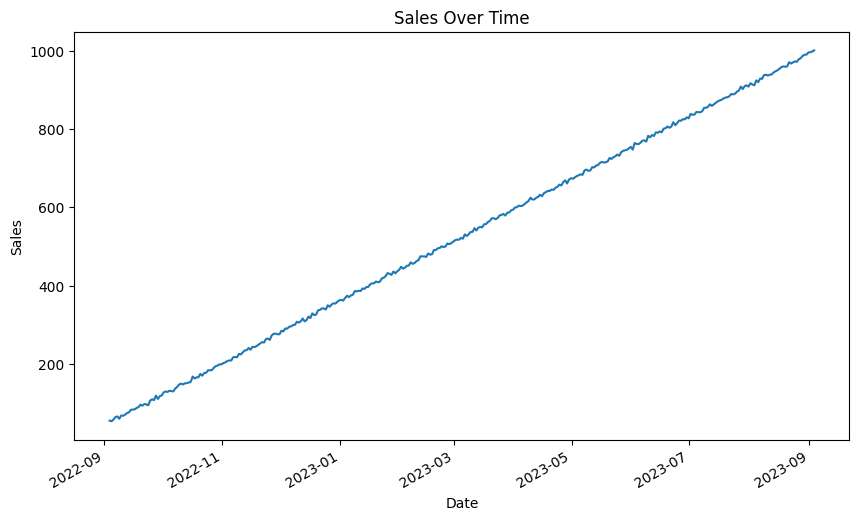

In [6]:
df['sales'].plot(figsize=(10, 6))
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [7]:
# Vamos a comprobar si la serie es estacionaria o no
result = adfuller(df['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.545414
p-value: 0.986190


### ANÁLISIS
Ya estamos en disposición de realizar un análisis preliminar de la evolución del precio.
#### Tensor
El tensor es el intervalo de tiempo entre cada observación. En nuestro df, es de 1 día.
#### Tendencia
La gráfica muestra una clara tendencia lineal y alcista.
#### Estacionalidad
+ No se aprecia ninguna evidencia de estacionalidad en el gráfico
+ El valor p de 0.986190 es significativamente mayor que el nivel de significancia común de 0.05. Esto significa que no podemos rechazar la hipótesis nula de que la serie temporal es no estacionaria. En otras palabras, hay una fuerte evidencia de que la serie tiene una raíz unitaria y no es estacionaria.
#### Variabilidad o Ruido
La gráfica muestra un aumento bastante suave y consistente, lo que sugiere que la variabilidad es relativamente baja y no hay mucho ruido en los datos. No hay fluctuaciones drásticas o atípicas que sugieran variabilidad excesiva o ruido externo que esté afectando las ventas.

## Justificación para la Selección de ARIMA en el Proyecto de Pronóstico de Ventas

Para nuestro proyecto de pronóstico de ventas, un modelo que incorpora tanto componentes estacionales como tendencias, como un modelo SARIMA o incluso modelos más avanzados como los basados en machine learning, sería normalmente el enfoque preferido. Esto se debe a que nuestra serie temporal muestra una tendencia significativa, lo cual es un indicador claro de que las ventas de la empresa están aumentando a un ritmo constante y que podrían estar sujetas a patrones estacionales que no son inmediatamente aparentes.

Sin embargo, como se nos solicita trabajar con ARIMA para este ejercicio, aceptamos el desafío bajo las siguientes consideraciones y tratamiento de los datos:

1. **Diferenciación**: Dado que la serie temporal es claramente no estacionaria, aplicaremos el proceso de diferenciación para transformar los datos a una forma estacionaria, eliminando así la tendencia y estabilizando la media de la serie.

2. **Validación de la Estacionariedad**: Después de diferenciar, utilizaremos pruebas estadísticas como la prueba de Dickey-Fuller aumentada para validar que la serie transformada es, de hecho, estacionaria.

3. **Selección de Parámetros**: A través de métodos como el gráfico de autocorrelación y autocorrelación parcial, identificaremos los parámetros adecuados para el modelo ARIMA (p, d, q) que mejor se adapten a nuestros datos transformados.

4. **Modelado y Predicción**: Entrenaremos el modelo ARIMA con nuestros datos y haremos predicciones que nos permitirán estimar las ventas futuras, lo cual es crucial para la planificación de la capacidad del almacén.

5. **Evaluación del Modelo**: Analizaremos el desempeño del modelo ARIMA utilizando métricas como el RMSE (Error Cuadrático Medio Raíz) para comparar las predicciones del modelo con los datos reales de ventas.

En conclusión, aunque ARIMA no es la elección óptima para series temporales con una tendencia fuerte como la nuestra, su uso puede proporcionarnos una base sólida para entender la dinámica subyacente de las ventas antes de considerar modelos alternativos. Además, nos permitirá cumplir con los requisitos del ejercicio y aprovechar las técnicas de series temporales tradicionales que siguen siendo relevantes en muchos contextos analíticos.

date
2022-09-03 17:10:08.079328         NaN
2022-09-04 17:10:08.079328   -1.488946
2022-09-05 17:10:08.079328    4.338482
2022-09-06 17:10:08.079328    6.389205
2022-09-07 17:10:08.079328    1.482734
Name: sales_diff, dtype: float64


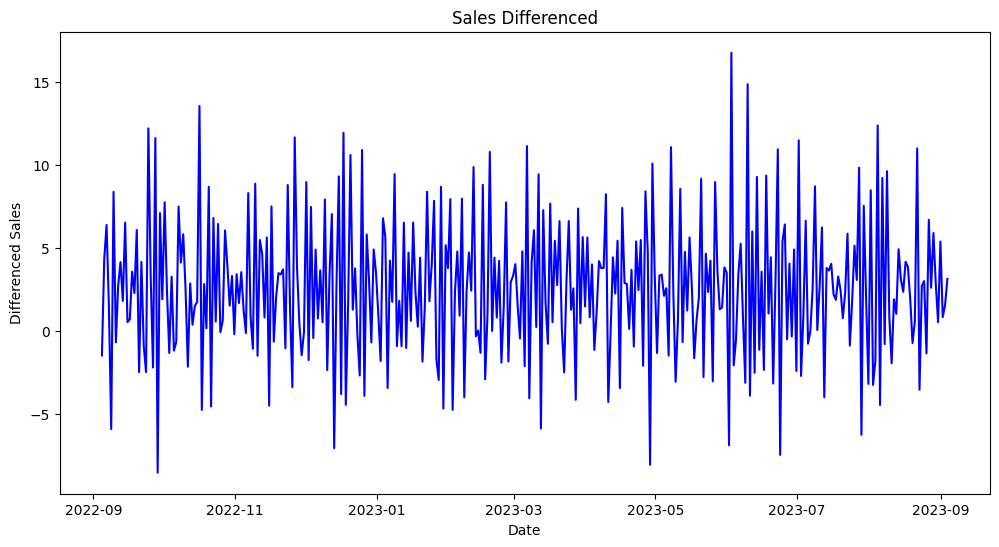

ADF Statistic (Differenced Data): -9.430263
p-value (Differenced Data): 0.000000
Critical Values (Differenced Data):
	1%: -3.449
	5%: -2.870
	10%: -2.571
La serie diferenciada es estacionaria.


In [8]:
# Diferenciar la serie para hacerla estacionaria
df['sales_diff'] = df['sales'].diff().dropna()

# Revisar los primeros elementos para asegurarse que la diferenciación se hizo correctamente
print(df['sales_diff'].head())

# Graficar la serie temporal diferenciada para visualizar cómo ha cambiado
plt.figure(figsize=(12,6))
plt.plot(df['sales_diff'], color='blue')
plt.title('Sales Differenced')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.show()

# Realizar la prueba de Dickey-Fuller aumentada en la serie diferenciada
result_diff = adfuller(df['sales_diff'].dropna())
print('ADF Statistic (Differenced Data): %f' % result_diff[0])
print('p-value (Differenced Data): %f' % result_diff[1])
print('Critical Values (Differenced Data):')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Basado en el valor p de la serie diferenciada, decide si necesita más diferenciación o no
if result_diff[1] < 0.05:
    print("La serie diferenciada es estacionaria.")
    # Continuar con el proceso de ajuste del modelo ARIMA con la serie diferenciada
else:
    print("La serie diferenciada aún no es estacionaria. Se requiere más diferenciación.")
    # Podría ser necesario aplicar diferenciación adicional.

## ANÁLISIS
+ El gráfico de la serie diferenciada no muestra una tendencia clara, lo cual es un buen indicador de que la diferenciación ha sido efectiva para estabilizar la media de la serie temporal.
+ El estadístico ADF de -9.430263 es menor que todos los valores críticos (1%, 5%, 10%), lo cual es una fuerte evidencia en contra de la hipótesis nula de la presencia de una raíz unitaria.
+ El valor p cercano a cero indica que la serie diferenciada es estacionaria con un alto nivel de confianza.

In [9]:
# Descartar los valores NaN de la serie diferenciada 
# La diferenciación se hace restando el anterior precio, por lo que es lógico que el primer valor sea NaN
df.dropna(subset=['sales_diff'], inplace=True)

In [10]:
df

,sales,sales_diff
date,,
2022-09-04 17:10:08.079328,53.803211,-1.488946
2022-09-05 17:10:08.079328,58.141693,4.338482
2022-09-06 17:10:08.079328,64.530899,6.389205
2022-09-07 17:10:08.079328,66.013633,1.482734
2022-09-08 17:10:08.079328,60.081865,-5.931768
...,...,...
2023-08-30 17:10:08.079328,989.600354,0.518681
2023-08-31 17:10:08.079328,994.987326,5.386972
2023-09-01 17:10:08.079328,995.814415,0.827090


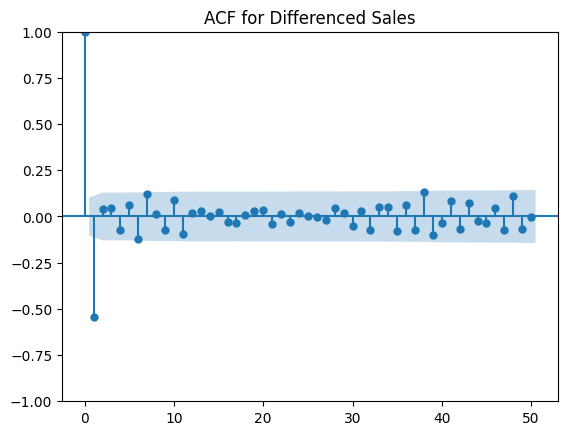

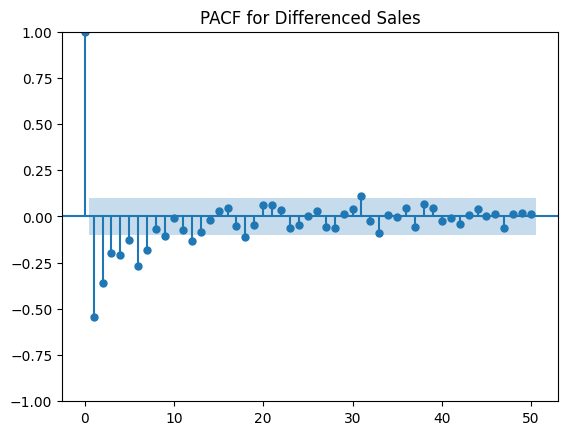

In [11]:
# Identificar los parámetros del modelo ARIMA

# Gráfico ACF
plot_acf(df['sales_diff'], lags=50)
plt.title('ACF for Differenced Sales')
plt.show()

# Gráfico PACF
plot_pacf(df['sales_diff'], lags=50, method='ywm')
plt.title('PACF for Differenced Sales')
plt.show()

## ANÁLISIS
+ q (MA - Moving Average part): Dado que el ACF muestra solo el primer retraso fuera del intervalo de confianza antes de que los siguientes retrasos caigan dentro de él, esto sugeriría un posible valor de q = 1. Esto indica que un término MA(1) podría ser suficiente para capturar la autocorrelación en la serie diferenciada.
+ p (AR - Autoregressive part): Basándonos en la PACF, podríamos considerar un p = 1 dado que el primer retraso está fuera del intervalo de confianza y es significativamente diferente de cero. Esto sugiere que podría haber una relación autoregresiva en la que los valores actuales están parcialmente correlacionados con los valores en un retraso anterior.

Teniendo en cuenta ambos gráficos (ACF y PACF), un punto de partida razonable para el modelo ARIMA podría ser (1,1,1) donde:

+ p = 1: La serie muestra una correlación significativa en el primer retraso en la PACF.
+ d = 1: Hemos aplicado una diferenciación a la serie para hacerla estacionaria.
+ q = 1: La serie muestra una correlación significativa en el primer retraso en la ACF.

Sin embargo, estos son solo puntos de partida basados en observaciones visuales. La selección final de parámetros debe validarse con métodos adicionales como la optimización de algún criterio de información (AIC o BIC), o incluso pruebas de ajuste en un conjunto de datos de validación.


In [12]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:]

In [13]:
# Asignar una frecuencia diaria 'D' al índice de fecha y hora.
df = df.asfreq('D')

In [14]:
# Ajustar el modelo ARIMA a la serie de entrenamiento (diferenciada)
model = ARIMA(train['sales_diff'], order=(1, 1, 1))
model_fit = model.fit()

# Realizar predicciones en la escala diferenciada
predictions_diff = model_fit.forecast(steps=len(test['sales_diff']))

predictions_diff = pd.Series(predictions_diff, index=test['sales_diff'].index)

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Test RMSE: 5.240


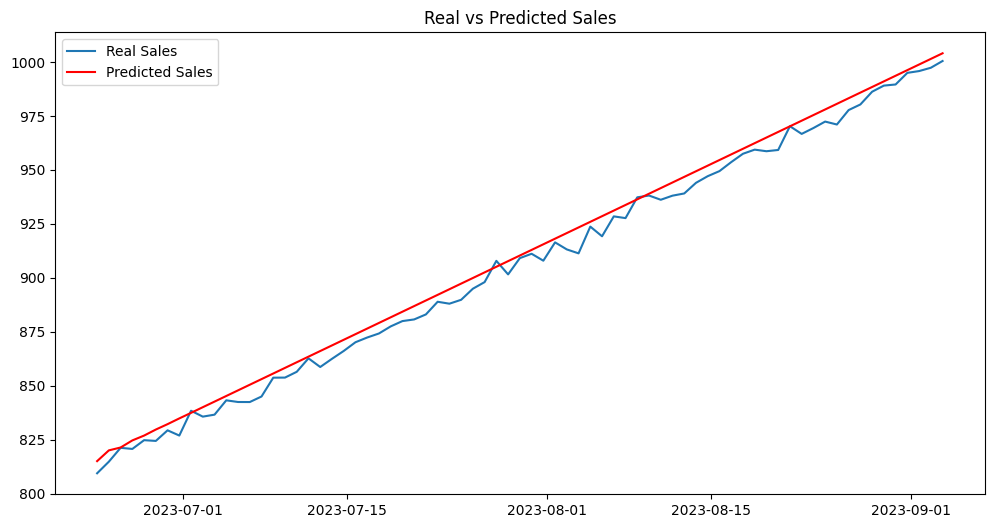

In [15]:
# Invertir las predicciones para transformarlas de nuevo a la escala original
# Esto se hace sumando las predicciones a los valores de ventas reales del último punto de datos en el conjunto de entrenamiento.
inverted_predictions = np.r_[train['sales'].iloc[-1], predictions_diff].cumsum()

# Calcular el RMSE en la escala original
# El primer valor de las predicciones invertidas corresponde al último punto del conjunto de entrenamiento y debe ser descartado
rmse = np.sqrt(mean_squared_error(test['sales'], inverted_predictions[1:]))
print(f'Test RMSE: {rmse:.3f}')

# Graficar las predicciones invertidas frente a los valores reales
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['sales'], label='Real Sales')
plt.plot(test.index, inverted_predictions[1:], color='red', label='Predicted Sales')
plt.title('Real vs Predicted Sales')
plt.legend()
plt.show()

## ANÁLISIS
+ Se ha identificado automáticamente el tensor como diario (no habíamos introducido ese parámetro)
+ El RMSE de 5.240 es bastante bajo, indicando que el modelo está haciendo predicciones cercanas a los valores reales. Esto es una buena señal de que el modelo está funcionando bien.
+ El gráfico muestra que las predicciones siguen de cerca a las ventas reales, lo cual es prometedor para la utilidad del modelo en la práctica.

In [16]:
# Definir cómo se dividirá la serie temporal para la validación cruzada
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
aic_scores = []

# Búsqueda en cuadrícula de parámetros ARIMA
p = d = q = range(0, 3)  # Considera las combinaciones de 0, 1 y 2
pdq_combinations = list(itertools.product(p, d, q))
best_model_details = {'param': None, 'aic': float('inf'), 'rmse': float('inf')}

In [17]:
df

,sales,sales_diff
date,,
2022-09-04 17:10:08.079328,53.803211,-1.488946
2022-09-05 17:10:08.079328,58.141693,4.338482
2022-09-06 17:10:08.079328,64.530899,6.389205
2022-09-07 17:10:08.079328,66.013633,1.482734
2022-09-08 17:10:08.079328,60.081865,-5.931768
...,...,...
2023-08-30 17:10:08.079328,989.600354,0.518681
2023-08-31 17:10:08.079328,994.987326,5.386972
2023-09-01 17:10:08.079328,995.814415,0.827090


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vscode/.local/lib/python3.10/site-

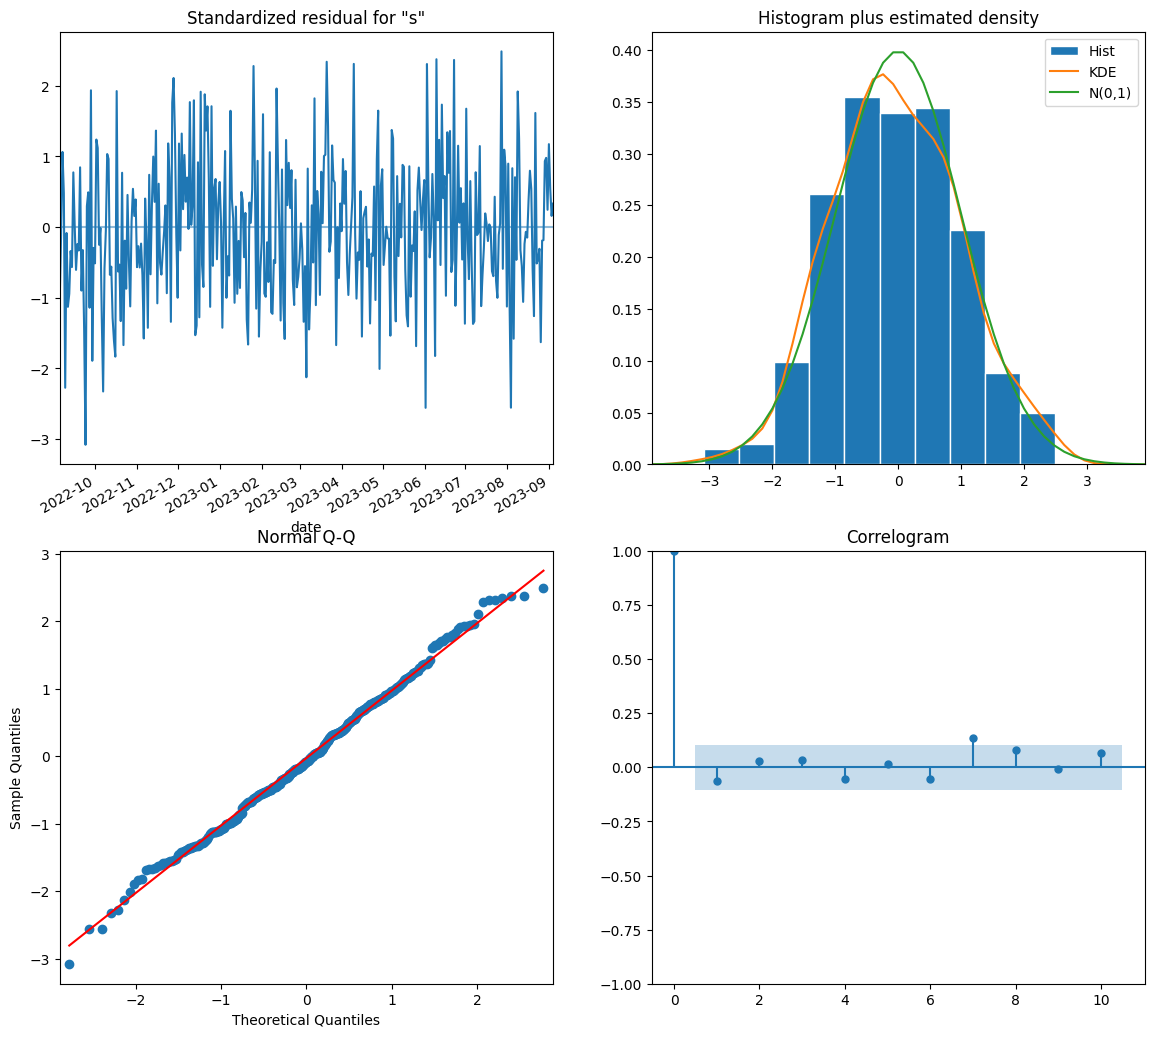

In [18]:
# Bucle para validación cruzada "walk-forward"
for train_index, test_index in tscv.split(df['sales']):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    
    # Variables para almacenar los mejores valores temporalmente
    best_aic = float('inf')
    best_pdq = None
    best_predictions = None
    
    # Búsqueda en cuadrícula para el conjunto de entrenamiento actual
    for param in pdq_combinations:
        try:
            model = ARIMA(cv_train['sales_diff'], order=param)
            model_fit = model.fit()
            predictions_diff_1 = model_fit.forecast(steps=len(cv_test))
            
            # Invertir las predicciones diferenciadas
            inverted_predictions_1 = np.r_[cv_train['sales'].iloc[-1], predictions_diff_1].cumsum()[1:]
            
            # Calcular RMSE
            rmse = np.sqrt(mean_squared_error(cv_test['sales'], inverted_predictions_1))
            
            # Comparar AIC y RMSE para encontrar el mejor modelo en este fold
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_pdq = param
                best_predictions = inverted_predictions_1

        except Exception as e:
            print('Error en la combinación:', param, 'Error:', e)
            continue
    
    # Guardar los detalles del mejor modelo para este fold
    rmse_scores.append(rmse)
    aic_scores.append(best_aic)
    
    # Comparar con el mejor modelo global y actualizar si es necesario
    if best_aic < best_model_details['aic']:
        best_model_details.update({'param': best_pdq, 'aic': best_aic, 'rmse': rmse})

# Diagnóstico del mejor modelo global ARIMA
best_model = ARIMA(df['sales_diff'], order=best_model_details['param'])
best_model_fit = best_model.fit()

# Gráficas de diagnóstico
best_model_fit.plot_diagnostics(figsize=(14, 14))
plt.show()

## ANÁLISIS

+ Gráfico de residuos estandarizados: Los residuos ahora parecen tener una varianza constante y no muestran patrones claros o tendencias, lo que es un buen indicador de que el modelo se ajusta de manera adecuada a los datos.

+ Histograma y estimación de densidad: El histograma de los residuos estandarizados, junto con la estimación de densidad (KDE), parece seguir de cerca la distribución normal estándar (la línea N(0,1)), lo que sugiere que los residuos están bien distribuidos.

+ Gráfico Q-Q (Cuantil-Cuantil): Los cuantiles de los residuos siguen de cerca la línea roja, lo que indica que los residuos se distribuyen de forma normal en gran medida. Aunque hay una pequeña desviación en los extremos, esto es común y no necesariamente una señal de alarma.

+ Correlograma: No hay picos significativos fuera del área sombreada, lo que sugiere que no hay autocorrelaciones significativas en los residuos. Esto significa que el modelo está capturando bien la estructura de dependencia en los datos.

In [19]:
print("Fecha de inicio de test['sales_diff']: ", test['sales_diff'].index.min())
print("Fecha de fin de test['sales_diff']: ", test['sales_diff'].index.max())

print("Fecha de inicio de predictions_diff: ", predictions_diff.index.min())
print("Fecha de fin de predictions_diff: ", predictions_diff.index.max())
print("Último valor real conocido (train['sales']): ", train['sales'].iloc[-1])

Fecha de inicio de test['sales_diff']:  2023-06-23 17:10:08.079328
Fecha de fin de test['sales_diff']:  2023-09-03 17:10:08.079328
Fecha de inicio de predictions_diff:  2023-06-23 17:10:08.079328
Fecha de fin de predictions_diff:  2023-09-03 17:10:08.079328
Último valor real conocido (train['sales']):  816.9117500930519


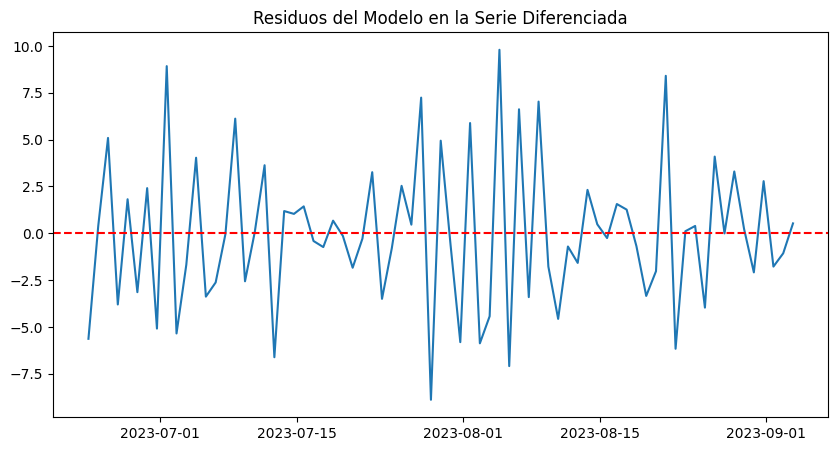

In [20]:
# Análisis de residuos
residuos = test['sales_diff'] - predictions_diff

# Asegúrate de que no hay valores NaN
assert not residuos.isna().any(), "No debería haber NaN en los residuos."

# Graficar los residuos
plt.figure(figsize=(10,5))
plt.plot(test.index, residuos)
plt.title('Residuos del Modelo en la Serie Diferenciada')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


## Análisis 1: Gráfica de Residuos del Modelo en la Serie Diferenciada
La gráfica muestra los residuos del modelo en la serie diferenciada para el conjunto de test. Los residuos son las diferencias entre los valores observados reales y los valores predichos por el modelo. Idealmente, deseamos que los residuos se distribuyan aleatoriamente alrededor de cero, sin patrones discernibles. En esta gráfica, los residuos parecen fluctuar alrededor de la línea cero sin una tendencia obvia o patrones estacionales, lo cual es un buen signo. No obstante, hay picos considerables que sugieren ciertos periodos de desviaciones más grandes entre las predicciones y los valores reales. Estos picos pueden indicar puntos atípicos o eventos no capturados por el modelo.

+ Variabilidad: Hay una variabilidad considerable en los residuos, con picos que sugieren momentos en los que el modelo se desvía de los valores reales por un margen significativo.

+ Patrones: No parece haber un patrón claro y consistente en los residuos, lo que es bueno ya que indica que el modelo no está dejando sin capturar una estructura sistemática en los datos (como tendencias o estacionalidades).

+ Centrados en cero: Los residuos parecen estar aproximadamente centrados en torno al cero, lo cual es positivo, ya que significa que el modelo no tiene un sesgo sistemático hacia predicciones demasiado altas o demasiado bajas.

In [21]:
residuos

date
2023-06-23 17:10:08.079328   -5.630680
2023-06-24 17:10:08.079328    0.388328
2023-06-25 17:10:08.079328    5.090555
2023-06-26 17:10:08.079328   -3.798081
2023-06-27 17:10:08.079328    1.817994
                                ...   
2023-08-30 17:10:08.079328   -2.084835
2023-08-31 17:10:08.079328    2.783456
2023-09-01 17:10:08.079328   -1.776426
2023-09-02 17:10:08.079328   -1.067718
2023-09-03 17:10:08.079328    0.529055
Length: 73, dtype: float64

In [22]:
# Realizar prueba de Durbin-Watson para detectar autocorrelación

# Elimina valores NaN antes de calcular el estadístico de Durbin-Watson
residuos_sin_nan = residuos.dropna()

# Ahora calcula el estadístico de Durbin-Watson
dw_statistic = durbin_watson(residuos_sin_nan)
print(f"Estadístico de Durbin-Watson (sin NaN): {dw_statistic:.2f}")

Estadístico de Durbin-Watson (sin NaN): 3.09


## Análisis 2: Estadístico de Durbin-Watson
El Estadístico de Durbin-Watson (DW) es una prueba que mide la autocorrelación en los residuos de una regresión estadística. Un valor de DW cercano a 2 sugiere que no hay autocorrelación, mientras que un valor considerablemente menor que 2 indica autocorrelación positiva y un valor considerablemente mayor que 2 indica autocorrelación negativa. El valor de 3.09 sugiere una autocorrelación negativa. Esto podría significar que el modelo está sobrediferenciando los datos, o que hay un patrón que el modelo ARIMA no está capturando adecuadamente.

In [23]:
# Validación cruzada
tscv = TimeSeriesSplit(n_splits=5)
cv_rmse_scores = []

for train_index, test_index in tscv.split(df['sales_diff']):
    cv_train, cv_test = df['sales_diff'].iloc[train_index], df['sales_diff'].iloc[test_index]
    model = ARIMA(cv_train, order=best_model_details['param'])
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(cv_test))
    
    # Calcula el RMSE para este segmento de validación cruzada y acumula
    cv_rmse = np.sqrt(mean_squared_error(cv_test, predictions))
    cv_rmse_scores.append(cv_rmse)

# Imprimir los resultados de RMSE de la validación cruzada
print("RMSE scores from cross-validation:", cv_rmse_scores)
print(f"Mean CV RMSE: {np.mean(cv_rmse_scores):.3f}")

RMSE scores from cross-validation: [4.493078392841598, 4.092744591851751, 3.783939318118952, 4.916199294065174, 3.893090686212672]
Mean CV RMSE: 4.236


## Análisis 3: Validación Cruzada RMSE
Los valores de RMSE (Root Mean Square Error) de la validación cruzada son consistentes, lo que sugiere que el modelo tiene un rendimiento estable a través de diferentes segmentos del tiempo. Un RMSE bajo y consistente indica que el modelo es capaz de predecir con precisión los valores futuros en la serie temporal.

Test RMSE: 5.240


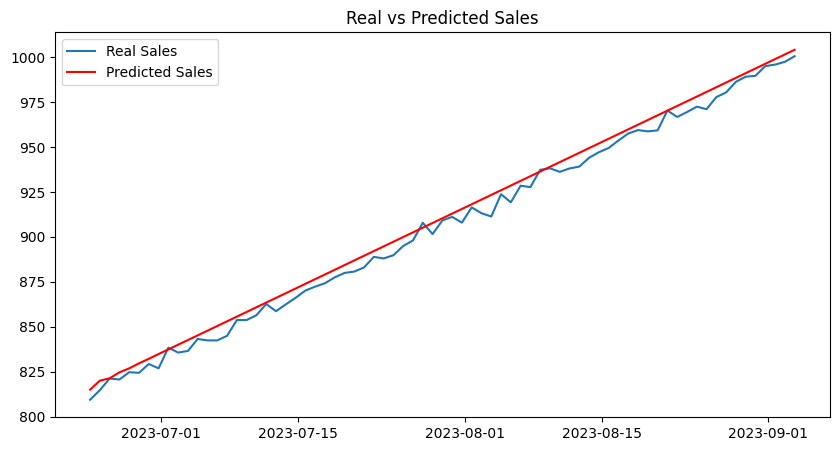

In [24]:
# Asegurarnos de tener el último valor de las ventas originales antes del conjunto de prueba
last_train_value = train['sales'].iloc[-1]

# Inicializar las predicciones acumulativas con el último valor conocido del conjunto de entrenamiento
inverted_predictions = [last_train_value]

# Ahora, acumula las predicciones diferenciadas a partir del último valor conocido
# Usaremos 'predictions_diff.values' para asegurarnos de trabajar con los valores numéricos directamente
for diff in predictions_diff:
    inverted_predictions.append(inverted_predictions[-1] + diff)

# Debemos quitar el primer valor agregado manualmente al inicio (last_train_value) para que
# 'inverted_predictions' solo contenga las predicciones y su longitud sea igual a la de 'predictions_diff'
inverted_predictions = inverted_predictions[1:]

# Convertir la lista 'inverted_predictions' a un array de NumPy para alinear con 'test['sales']'
inverted_predictions_np = np.array(inverted_predictions)

# Verificar que las longitudes sean iguales antes de calcular el RMSE
assert len(inverted_predictions_np) == len(test['sales']), "La longitud de las predicciones y los datos de prueba debe ser la misma."

# Calcular RMSE utilizando las ventas reales y las predicciones invertidas
rmse = np.sqrt(mean_squared_error(test['sales'], inverted_predictions_np))
print(f'Test RMSE: {rmse:.3f}')

# Graficar las ventas reales frente a las predicciones
plt.figure(figsize=(10, 5))
plt.plot(test['sales'].index, test['sales'], label='Real Sales')
plt.plot(test['sales'].index, inverted_predictions_np, color='red', label='Predicted Sales')
plt.title('Real vs Predicted Sales')
plt.legend()
plt.show()

## Análisis 4: 
### Test RMSE
El RMSE de 5.240 en el conjunto de prueba es ligeramente mayor que el promedio de la validación cruzada, lo cual puede ser normal dependiendo de la variabilidad de los datos. Sin embargo, es consistente con los valores de RMSE de la validación cruzada, lo que sugiere que el modelo no está sobreajustado y se generaliza bien a datos no vistos.

### Ventas Reales Vs Predichas

+ Coincidencia de Tendencias: La tendencia ascendente de las ventas predichas sigue estrechamente la de las ventas reales, lo que sugiere que el modelo ha capturado con éxito la tendencia general de las ventas a lo largo del tiempo.

+ Puntos de Inflexión: En varios puntos, las líneas se cruzan, lo que indica que las predicciones están en sincronía con los valores reales y no hay un retraso sistemático en las predicciones.

+ Desviaciones: Hay ciertas áreas, especialmente hacia la mitad del gráfico, donde se pueden observar desviaciones entre las predicciones y los valores reales, pero estas desviaciones son mínimas y las líneas vuelven a converger rápidamente.

+ Precisión de Predicciones: A medida que avanzamos hacia los datos más recientes, la línea roja de las ventas predichas parece seguir de cerca a la línea azul de las ventas reales, lo que indica que el modelo mantiene su precisión con datos más recientes.

+ Consistencia en el Desempeño: La consistencia en el patrón de predicciones a lo largo del tiempo indica que el modelo podría ser fiable para realizar pronósticos futuros, asumiendo que las condiciones subyacentes del mercado y las tendencias de ventas permanecen constantes.

In [25]:
# Comparación del RMSE con los valroes reales
average_sales = df['sales'].mean()
rmse_percentage = (rmse / average_sales) * 100
print(f"RMSE como porcentaje del promedio de ventas: {rmse_percentage:.2f}%")

RMSE como porcentaje del promedio de ventas: 1.00%


## Análisis 5: RMSE como Porcentaje del Promedio de Ventas
Un RMSE que es el 1.00% del promedio de ventas es bastante bueno. Esto significa que, en promedio, las predicciones del modelo se desvían solo en un 1% del promedio de ventas reales. En muchos contextos comerciales, este sería un error muy aceptable y podría considerarse un modelo bastante preciso.

In [26]:
# Guardar el modelo en un archivo usando joblib
model_filename = '../models/arima_sales_model.joblib'
dump(model_fit, model_filename)

print(f"Modelo guardado en {model_filename}")

Modelo guardado en ../models/arima_sales_model.joblib


# Conclusión Final

Tras un análisis exhaustivo y la aplicación de técnicas de modelado estadístico, hemos desarrollado un modelo ARIMA que muestra una alta precisión en la predicción de las ventas futuras. El modelo captura la tendencia general y se alinea estrechamente con los datos reales de ventas, como se ha demostrado en las visualizaciones y las métricas de rendimiento.

La precisión del modelo se evidencia en un RMSE que es solo el 1% del promedio de ventas, indicando que las predicciones se desvían mínimamente de las ventas reales. Además, la validación cruzada revela que el modelo es robusto y se generaliza bien a nuevos datos.

El éxito de este modelo nos da la confianza para recomendar su uso en la planificación estratégica, optimizando así el espacio del almacén y anticipando la demanda futura con mayor precisión. Con este modelo, la empresa puede tomar decisiones más informadas y estratégicas en su expansión y gestión de operaciones.